Context
This dataset (source) consists of data from almost 10,000 borrowers that took loans - with some paid back and others still in progress. It was extracted from lendingclub.com which is an organization that connects borrowers with investors. We've included a few suggested questions at the end of this template to help you get started.

In [1]:
# Load packages
# Import 
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from timeit import default_timer as timer
import time

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.svm import SVR
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import plot_partial_dependence
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report, precision_recall_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from sklearn.utils import resample,shuffle
# Import necessary modules
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE

# Others
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

cmap=sns.color_palette('Blues_r')

In [2]:
# Load data from the csv file
df = pd.read_csv('loan_data.csv', index_col=None)

# Change the dots in the column names to underscores
df.columns = [c.replace(".", "_") for c in df.columns]
print(f"Number of rows/records: {df.shape[0]}")
print(f"Number of columns/variables: {df.shape[1]}")

Number of rows/records: 9578
Number of columns/variables: 14


In [3]:
# Understand your variables
variables = pd.DataFrame(columns=['Variable','Number of unique values','Values'])

for i, var in enumerate(df.columns):
    variables.loc[i] = [var, df[var].nunique(), df[var].unique().tolist()]
    
# Join with the variables dataframe
var_dict = pd.read_csv('variable_explanation.csv', index_col=0)
variables.set_index('Variable').join(var_dict)

,Number of unique values,Values,Explanation
Variable,,,
credit_policy,2,"[1, 0]",1 if the customer meets the credit underwritin...
purpose,7,"[debt_consolidation, credit_card, all_other, h...",The purpose of the loan.
int_rate,249,"[0.1189, 0.1071, 0.1357, 0.1008, 0.1426, 0.078...",The interest rate of the loan (more risky borr...
installment,4788,"[829.1, 228.22, 366.86, 162.34, 102.92, 125.13...",The monthly installments owed by the borrower ...
log_annual_inc,1987,"[11.35040654, 11.08214255, 10.37349118, 11.299...",The natural log of the self-reported annual in...
dti,2529,"[19.48, 14.29, 11.63, 8.1, 14.97, 16.98, 4.0, ...",The debt-to-income ratio of the borrower (amou...
fico,44,"[737, 707, 682, 712, 667, 727, 722, 677, 662, ...",The FICO credit score of the borrower.
days_with_cr_line,2687,"[5639.958333, 2760.0, 4710.0, 2699.958333, 406...",The number of days the borrower has had a cred...
revol_bal,7869,"[28854, 33623, 3511, 33667, 4740, 50807, 3839,...",The borrower's revolving balance (amount unpai...


In [4]:
# Create train and test sets
train, test = train_test_split(df, test_size=0.2, random_state=0)
train, valid = train_test_split(df, test_size=0.2, random_state=0)
train.head()

,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid
4247,1,major_purchase,0.0774,156.10,10.584056,10.27,797,5490.000000,2629,8.8,2,0,0,0
8766,0,all_other,0.1064,50.49,10.308953,15.60,697,6389.958333,1085,11.4,11,1,0,0
1509,1,debt_consolidation,0.1399,854.32,11.695247,19.76,692,3780.041667,41077,60.0,0,1,0,0
6120,1,debt_consolidation,0.1218,807.53,10.907386,17.41,737,4111.041667,28559,73.2,0,0,0,1
1069,1,debt_consolidation,0.1071,244.52,11.289682,13.02,702,3479.958333,8709,30.1,3,0,0,0


In [6]:
# Train: X and y split
X_train = train.drop('not_fully_paid', axis=1)
y_train = train[['not_fully_paid']]
X_train.head()
y_train.head()

,not_fully_paid
4247,0
8766,0
1509,0
6120,1
1069,0


In [7]:
# Train: X and y split
X_test = test.drop('not_fully_paid', axis=1)
y_test = test[['not_fully_paid']]
X_test.head()

,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec
3343,1,all_other,0.1189,49.75,10.829729,16.87,687,2314.958333,962,64.1,0,0,0
9,1,debt_consolidation,0.1221,84.12,10.203592,10.00,707,2730.041667,5630,23.0,1,0,0
1741,1,debt_consolidation,0.1695,712.54,11.918391,13.61,672,4830.041667,16473,94.1,2,2,0
5160,1,debt_consolidation,0.1739,286.78,11.189962,19.59,667,7020.000000,19892,67.0,1,0,1
7760,0,credit_card,0.1312,202.51,9.392662,4.40,657,898.958333,5251,49.3,9,0,0


In [8]:
# Train: X and y split
X_valid = valid.drop('not_fully_paid', axis=1)
y_valid = test[['not_fully_paid']]
X_valid.head()

,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec
3343,1,all_other,0.1189,49.75,10.829729,16.87,687,2314.958333,962,64.1,0,0,0
9,1,debt_consolidation,0.1221,84.12,10.203592,10.00,707,2730.041667,5630,23.0,1,0,0
1741,1,debt_consolidation,0.1695,712.54,11.918391,13.61,672,4830.041667,16473,94.1,2,2,0
5160,1,debt_consolidation,0.1739,286.78,11.189962,19.59,667,7020.000000,19892,67.0,1,0,1
7760,0,credit_card,0.1312,202.51,9.392662,4.40,657,898.958333,5251,49.3,9,0,0


In [9]:
# Check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9578 entries, 0 to 9577
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_policy      9578 non-null   int64  
 1   purpose            9578 non-null   object 
 2   int_rate           9578 non-null   float64
 3   installment        9578 non-null   float64
 4   log_annual_inc     9578 non-null   float64
 5   dti                9578 non-null   float64
 6   fico               9578 non-null   int64  
 7   days_with_cr_line  9578 non-null   float64
 8   revol_bal          9578 non-null   int64  
 9   revol_util         9578 non-null   float64
 10  inq_last_6mths     9578 non-null   int64  
 11  delinq_2yrs        9578 non-null   int64  
 12  pub_rec            9578 non-null   int64  
 13  not_fully_paid     9578 non-null   int64  
dtypes: float64(6), int64(7), object(1)
memory usage: 1.0+ MB


In [10]:
# Split col by data type
num = ['credit_policy', 'int_rate', 'installment', 'log_annual_inc', 'dti', 'fico', 'days_with_cr_line', 'revol_bal', 'revol_util', 'inq_last_6mths', 'delinq_2yrs', 'pub_rec']
non_num = ['purpose']

In [11]:
# Check distribution of num values
X_train[num].describe()

,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec
count,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7.662000e+03,7662.000000,7662.000000,7662.000000,7662.000000
mean,0.805664,0.122471,319.821534,10.942256,12.532610,711.070086,4588.193955,1.720949e+04,46.793504,1.582485,0.163665,0.064866
std,0.395714,0.026808,207.166705,0.613794,6.889475,37.914312,2536.972522,3.501028e+04,29.021155,2.197629,0.551577,0.270066
min,0.000000,0.060000,15.690000,7.600902,0.000000,612.000000,180.041667,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.103450,164.320000,10.571317,7.140000,682.000000,2820.000000,3.180250e+03,22.325000,0.000000,0.000000,0.000000
50%,1.000000,0.122100,269.070000,10.933107,12.580000,707.000000,4140.000000,8.596000e+03,46.300000,1.000000,0.000000,0.000000
75%,1.000000,0.139200,434.352500,11.314475,17.857500,737.000000,5760.041667,1.847525e+04,71.000000,2.000000,0.000000,0.000000
max,1.000000,0.216400,926.830000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,108.800000,33.000000,13.000000,5.000000


=== Distribution of features (before log transformation) ===


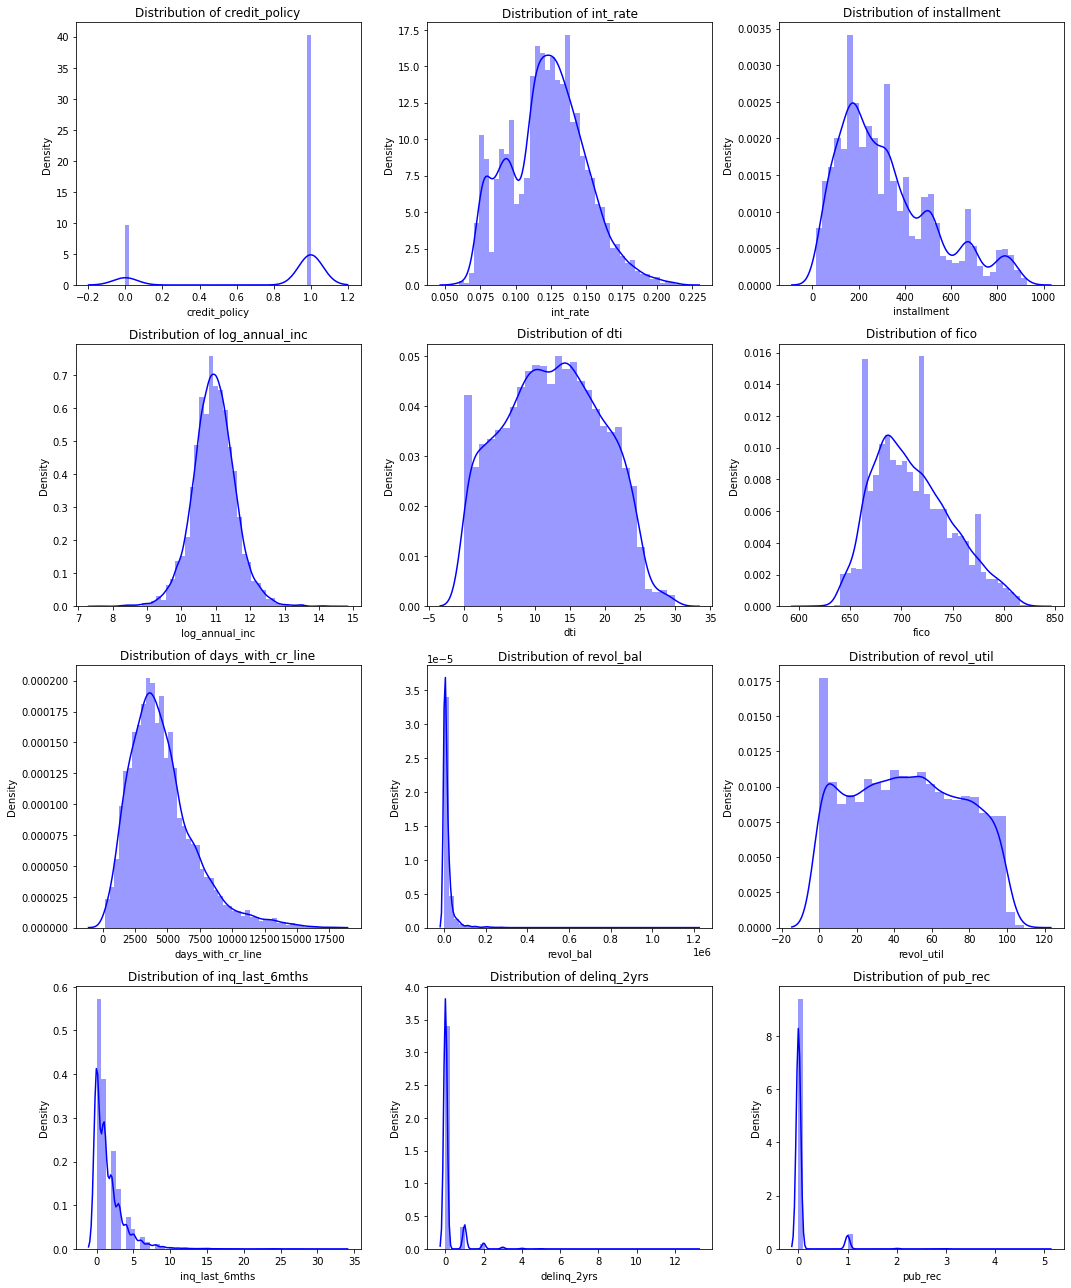

In [12]:
# Check distribution (num)
print(f'=== Distribution of features (before log transformation) ===')
plt.figure(figsize=(15, 18))
for i, col in enumerate(num):
    # Plot distribution 
    plt.subplot(4,3,i+1); sns.distplot(X_train[col], color='blue')
    plt.title(f'Distribution of {col}')
# Show the plot
plt.tight_layout()
plt.show()

In [13]:
# Log transform function
def log_transform(data, to_log):
    X = data.copy()
    for item in to_log:
        # Add 1 to the data to prevent infinity values
        X[item] = np.log(1+X[item])
    return X


In [14]:
# Display unique values in cat data
X_train['purpose'].unique()

array(['major_purchase', 'all_other', 'debt_consolidation', 'credit_card',
       'home_improvement', 'small_business', 'educational'], dtype=object)

In [15]:
# Transform categorial features to num 
X_train_e = pd.get_dummies(data=X_train)
X_train_e = X_train_e.drop(['purpose_all_other'], axis=1)

X_test_e = pd.get_dummies(data=X_test)
X_test_e = X_test_e.drop(['purpose_all_other'], axis=1)

X_valid_e = pd.get_dummies(data=X_valid)
X_valid_e = X_valid_e.drop(['purpose_all_other'], axis=1)

In [16]:
# Log transform
to_log = ['credit_policy', 'int_rate', 'installment', 'dti', 'fico', 'days_with_cr_line', 'revol_bal', 'revol_util', 'inq_last_6mths', 'delinq_2yrs', 'pub_rec']
X_train_e_l = log_transform(X_train_e, to_log)
X_test_e_l = log_transform(X_test_e, to_log)
X_valid_e_l = log_transform(X_valid_e, to_log)
X_train_e_l.head()

,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
4247,0.693147,0.074551,5.056883,10.584056,2.422144,6.682109,8.610866,7.874739,2.282382,1.098612,0.000000,0.0,0,0,0,0,1,0
8766,0.000000,0.101112,3.941388,10.308953,2.809403,6.548219,8.762640,6.990257,2.517696,2.484907,0.693147,0.0,0,0,0,0,0,0
1509,0.693147,0.130941,6.751476,11.695247,3.033028,6.541030,8.237755,10.623228,4.110874,0.000000,0.693147,0.0,0,1,0,0,0,0
6120,0.693147,0.114935,6.695218,10.907386,2.912894,6.603944,8.321675,10.259762,4.306764,0.000000,0.000000,0.0,0,1,0,0,0,0
1069,0.693147,0.101744,5.503378,11.289682,2.640485,6.555357,8.155063,9.072227,3.437208,1.386294,0.000000,0.0,0,1,0,0,0,0


In [17]:
X_train_e_l.describe()

,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
count,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000,7662.000000
mean,0.558444,0.115248,5.538689,10.942256,2.408858,6.566778,8.270154,8.632424,3.503761,0.705485,0.097164,0.043538,0.134691,0.407857,0.035108,0.067345,0.044897,0.064996
std,0.274288,0.023849,0.729591,0.613794,0.724316,0.052720,0.607116,2.144157,1.097500,0.664321,0.282366,0.174050,0.341415,0.491468,0.184066,0.250635,0.207091,0.246535
min,0.000000,0.058269,2.814810,7.600902,0.000000,6.418365,5.198727,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.693147,0.098442,5.107883,10.571317,2.096790,6.526495,7.944847,8.065029,3.149524,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.693147,0.115202,5.598681,10.933107,2.608598,6.562444,8.328693,9.059169,3.856510,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.693147,0.130326,6.076154,11.314475,2.936911,6.603944,8.658874,9.824241,4.276666,1.098612,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,0.693147,0.195896,6.832849,14.528354,3.432696,6.719013,9.777979,14.003947,4.698661,3.526361,2.639057,1.791759,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


=== Distribution of features (after log transformation) ===


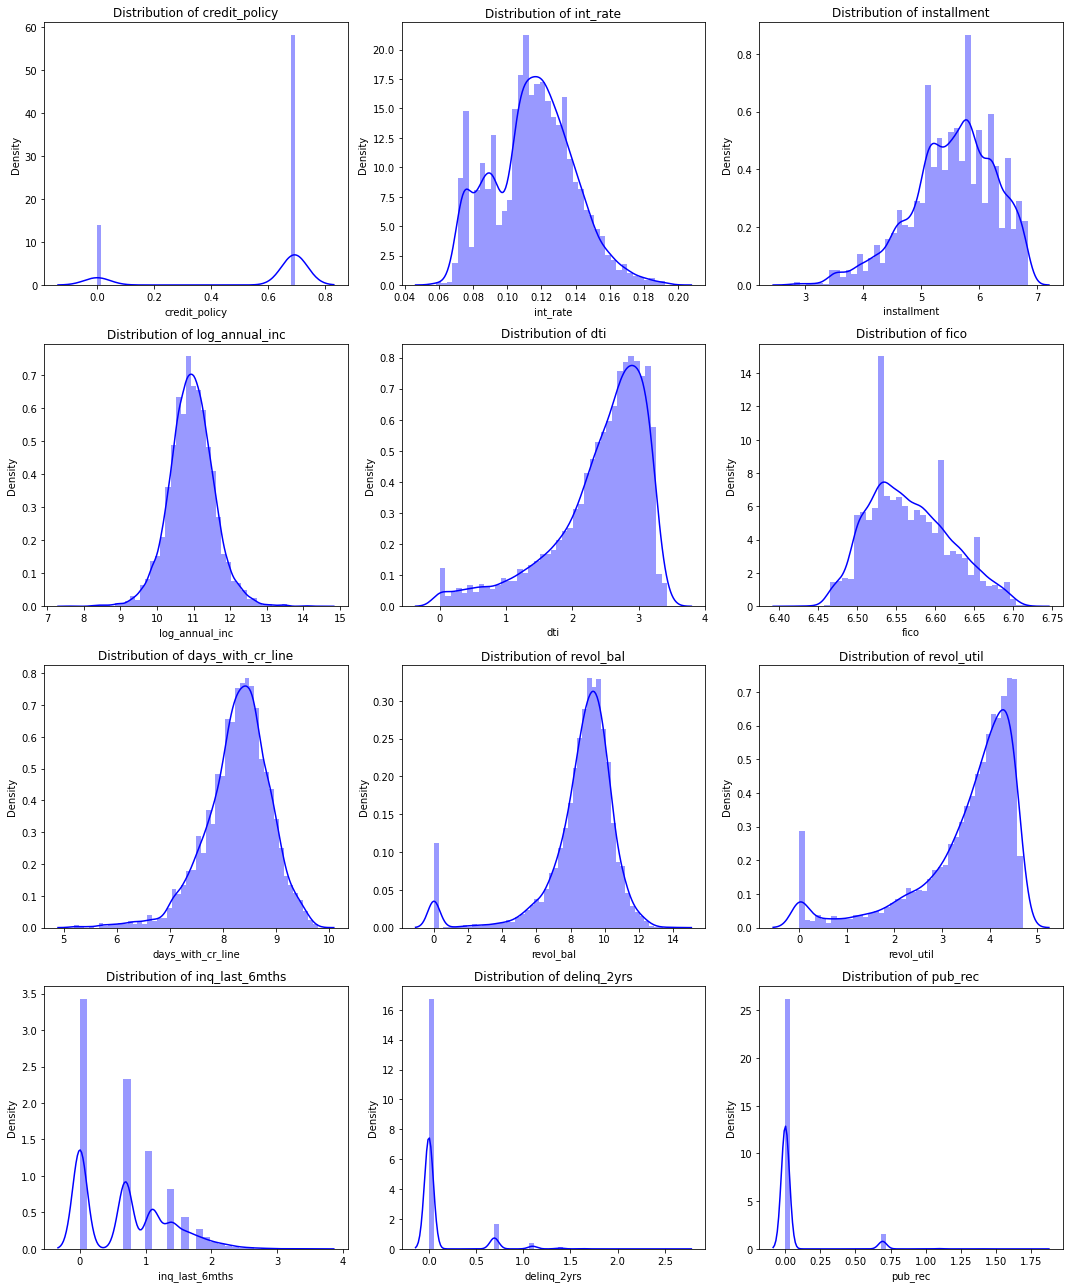

In [18]:
# Check distribution (num)
print(f'=== Distribution of features (after log transformation) ===')
plt.figure(figsize=(15, 18))
for i, col in enumerate(num):
    # Plot distribution 
    plt.subplot(4,3,i+1); sns.distplot(X_train_e_l[col], color='blue')
    plt.title(f'Distribution of {col}')
# Show the plot
plt.tight_layout()
plt.show()

In [19]:
# Initialize a standard scaler and fit it
scaler = StandardScaler()
scaler.fit(X_train_e_l)

# Scale and center the data
tmp_train = scaler.transform(X_train_e_l)
tmp_test = scaler.transform(X_test_e_l)
tmp_valid = scaler.transform(X_valid_e_l)

# Create a pandas DataFrame
X_train_e_l_n = pd.DataFrame(data=tmp_train, index=X_train_e.index, columns=X_train_e.columns)    
X_test_e_l_n = pd.DataFrame(data=tmp_test, index=X_test_e.index, columns=X_test_e.columns) 
X_valid_e_l_n = pd.DataFrame(data=tmp_valid, index=X_valid_e.index, columns=X_valid_e.columns) 

In [20]:
X_train_e_l_n.head()

,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
4247,0.491133,-1.706565,-0.660422,-0.583622,0.018345,2.187756,0.561234,-0.353395,-1.112946,0.591812,-0.344128,-0.250163,-0.394533,-0.829928,-0.190751,-0.268716,4.612294,-0.263656
8766,-2.036108,-0.592791,-2.189453,-1.031852,0.553034,-0.352051,0.811242,-0.765930,-0.898523,2.678732,2.110818,-0.250163,-0.394533,-0.829928,-0.190751,-0.268716,-0.216812,-0.263656
1509,0.491133,0.658032,1.662392,1.226862,0.861794,-0.488425,-0.053369,0.928539,0.553214,-1.062034,2.110818,-0.250163,-0.394533,1.204923,-0.190751,-0.268716,-0.216812,-0.263656
6120,0.491133,-0.013149,1.585278,-0.056814,0.695924,0.705015,0.084867,0.759014,0.731713,-1.062034,-0.344128,-0.250163,-0.394533,1.204923,-0.190751,-0.268716,-0.216812,-0.263656
1069,0.491133,-0.566269,-0.048401,0.566067,0.319808,-0.216652,-0.189583,0.205130,-0.060645,1.024887,-0.344128,-0.250163,-0.394533,1.204923,-0.190751,-0.268716,-0.216812,-0.263656


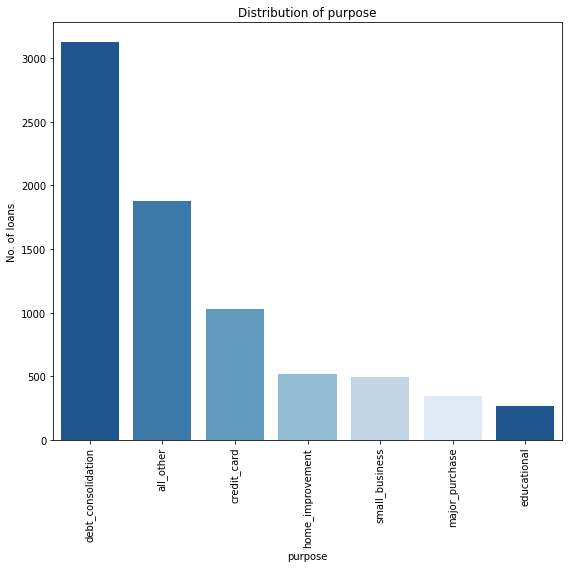

In [21]:
# Check distribution (non-num)
plt.figure(figsize=(8, 8))
# Plot distribution 
for i, col in enumerate(['purpose']):
    order = train[col].value_counts().index   
    plt.subplot(1,1,i+1); sns.countplot(train[col],palette=cmap, order = order ) 
    plt.title(f'Distribution of {col}')
    plt.ylabel('No. of loans')
    plt.xticks(rotation=90)
# Show the plot
plt.tight_layout()
plt.show()

In [22]:
X_train[['purpose']].describe()

,purpose
count,7662
unique,7
top,debt_consolidation
freq,3125


In [23]:
# Plot tsne scatter plot
def tsne_scatterplot(data, hue):
    # Color the points 
    sns.scatterplot(x="t_SNE_PC_1", y="t_SNE_PC_2", hue=hue, data=data, alpha=0.3)
    plt.title(hue)

In [24]:
# Create a t-SNE model with learning rate 50
m = TSNE(learning_rate=50)

In [25]:
X_train_num_l_n = X_train_e_l_n[num]
X_train_num_l_n.head()

,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec
4247,0.491133,-1.706565,-0.660422,-0.583622,0.018345,2.187756,0.561234,-0.353395,-1.112946,0.591812,-0.344128,-0.250163
8766,-2.036108,-0.592791,-2.189453,-1.031852,0.553034,-0.352051,0.811242,-0.765930,-0.898523,2.678732,2.110818,-0.250163
1509,0.491133,0.658032,1.662392,1.226862,0.861794,-0.488425,-0.053369,0.928539,0.553214,-1.062034,2.110818,-0.250163
6120,0.491133,-0.013149,1.585278,-0.056814,0.695924,0.705015,0.084867,0.759014,0.731713,-1.062034,-0.344128,-0.250163
1069,0.491133,-0.566269,-0.048401,0.566067,0.319808,-0.216652,-0.189583,0.205130,-0.060645,1.024887,-0.344128,-0.250163


In [27]:
# Fit and transform the 
tsne_features = m.fit_transform(X_train_num_l_n)
print(tsne_features.shape)

(7662, 2)


In [28]:
# Create df
df_tsne = y_train.copy()
df_tsne = pd.concat([X_train, y_train], axis=1)
df_tsne['t_SNE_PC_1'] = tsne_features[:,0]
df_tsne['t_SNE_PC_2'] = tsne_features[:,1]
df_tsne.head()

,credit_policy,purpose,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid,t_SNE_PC_1,t_SNE_PC_2
4247,1,major_purchase,0.0774,156.10,10.584056,10.27,797,5490.000000,2629,8.8,2,0,0,0,-19.371683,-6.639545
8766,0,all_other,0.1064,50.49,10.308953,15.60,697,6389.958333,1085,11.4,11,1,0,0,-0.246969,-45.589073
1509,1,debt_consolidation,0.1399,854.32,11.695247,19.76,692,3780.041667,41077,60.0,0,1,0,0,-34.980030,-43.901581
6120,1,debt_consolidation,0.1218,807.53,10.907386,17.41,737,4111.041667,28559,73.2,0,0,0,1,29.996908,21.266382
1069,1,debt_consolidation,0.1071,244.52,11.289682,13.02,702,3479.958333,8709,30.1,3,0,0,0,-30.414579,17.936140


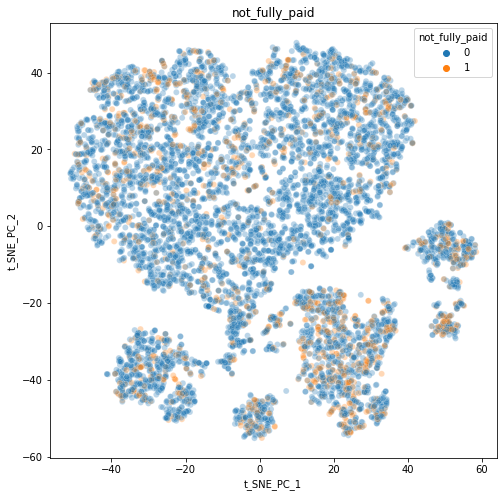

In [29]:
# Viz of y
plt.figure(figsize=(8,8))

# y 
tsne_scatterplot(df_tsne, 'not_fully_paid')
# Plot
plt.show()

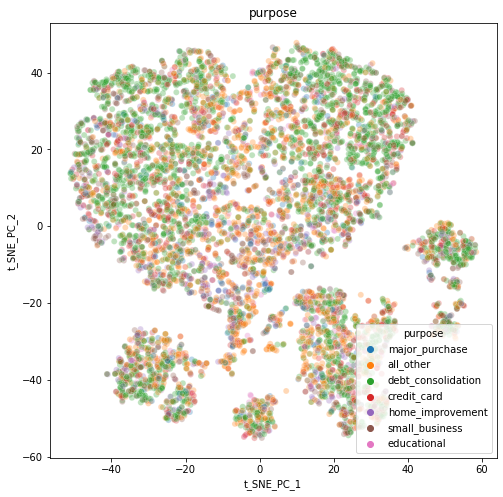

In [30]:
# Viz of purpose
plt.figure(figsize=(8,8))

# y 
tsne_scatterplot(df_tsne, 'purpose')
# Plot
plt.show()

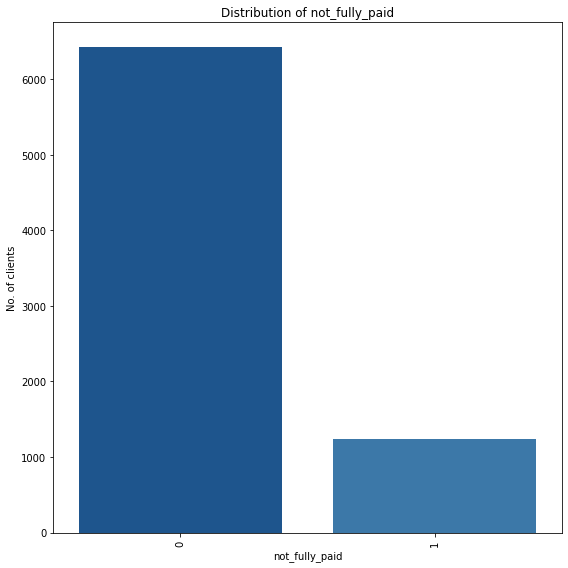

In [31]:
# Check distribution (non-num)
plt.figure(figsize=(8, 8))
# Plot distribution 
for i, col in enumerate(['not_fully_paid']):
    order = train[col].value_counts().index   
    plt.subplot(1,1,i+1); sns.countplot(train[col],palette=cmap, order = order ) 
    plt.title(f'Distribution of {col}')
    plt.ylabel('No. of clients')
    plt.xticks(rotation=90)
# Show the plot
plt.tight_layout()
plt.show()

At this juncture, we argue that recall is the most important performance metric for our modelling purpose.
This is because if a loan is not fully paid, the lender will incur high default risk. Thus, it is more important to have a good recall (low FN) instead of a high precision (low FP). In cases of FN, the lender will lose huge amount of monies due to default and this is highly undesirable. On the other hand, in cases of FP, the lender loses only potential revenue (at the expense of lower default risk) which we believe is comparatively acceptable.

In [32]:
def stack_bar(d, xlabel, hue = 'lead_type'):
    plt.figure(figsize=(5, 5))
    train_pct = (d.groupby([xlabel,hue])['credit_policy'].count()/d.groupby([xlabel])['credit_policy'].count())
    train_pct.unstack().plot.bar(stacked=True)
    plt.ylabel('%') 
    plt.title(f'100% stack bar chart \n By {xlabel}')
    plt.show() 

<Figure size 360x360 with 0 Axes>

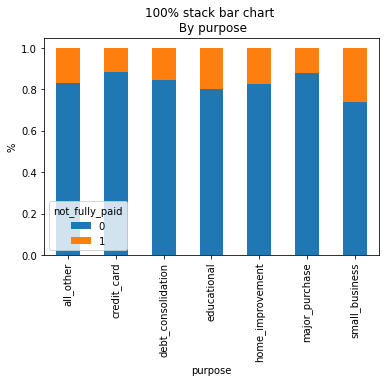

In [33]:
stack_bar(train, 'purpose', 'not_fully_paid')

In [34]:
# Convert target var to a categorial var
train['y'] = np.where(train['not_fully_paid']==1, 'yes', 'no')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7662 entries, 4247 to 2732
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   credit_policy      7662 non-null   int64  
 1   purpose            7662 non-null   object 
 2   int_rate           7662 non-null   float64
 3   installment        7662 non-null   float64
 4   log_annual_inc     7662 non-null   float64
 5   dti                7662 non-null   float64
 6   fico               7662 non-null   int64  
 7   days_with_cr_line  7662 non-null   float64
 8   revol_bal          7662 non-null   int64  
 9   revol_util         7662 non-null   float64
 10  inq_last_6mths     7662 non-null   int64  
 11  delinq_2yrs        7662 non-null   int64  
 12  pub_rec            7662 non-null   int64  
 13  not_fully_paid     7662 non-null   int64  
 14  y                  7662 non-null   object 
dtypes: float64(6), int64(7), object(2)
memory usage: 1.2+ MB


In [35]:
# Not fully paid 
train[train['y']=='yes'].describe()

,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid
count,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1232.000000,1.232000e+03,1232.000000,1232.000000,1232.000000,1232.000000,1232.0
mean,0.657468,0.132217,339.906583,10.888878,13.142516,697.957792,4455.193283,2.114125e+04,52.642638,2.370942,0.173701,0.092532,1.0
std,0.474749,0.025369,222.561810,0.663654,7.056859,33.611120,2495.372138,5.197035e+04,29.199771,2.986495,0.521533,0.292683,0.0
min,0.000000,0.070500,15.910000,7.600902,0.000000,627.000000,180.041667,0.000000e+00,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,0.115250,167.952500,10.491274,7.670000,672.000000,2819.729167,3.315750e+03,30.550000,0.000000,0.000000,0.000000,1.0
50%,1.000000,0.131600,285.500000,10.896739,13.160000,692.000000,4079.979167,8.772000e+03,54.500000,1.000000,0.000000,0.000000,1.0
75%,1.000000,0.147400,486.182500,11.289782,18.822500,717.000000,5642.010417,2.029175e+04,77.725000,3.000000,0.000000,0.000000,1.0
max,1.000000,0.216400,926.830000,13.458836,29.960000,822.000000,15692.000000,1.207359e+06,106.500000,33.000000,4.000000,2.000000,1.0


In [36]:
# fully paid 
train[train['y']=='no'].describe()

,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,not_fully_paid
count,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.000000,6430.0
mean,0.834059,0.120604,315.973201,10.952483,12.415751,713.582426,4613.677132,16456.155521,45.672799,1.431415,0.161742,0.059565,0.0
std,0.372057,0.026673,203.877046,0.603287,6.851301,38.175805,2544.263439,30658.033085,28.854027,1.976186,0.557167,0.265208,0.0
min,0.000000,0.060000,15.690000,8.294050,0.000000,612.000000,180.041667,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,1.000000,0.098800,163.762500,10.596535,7.032500,682.000000,2820.000000,3162.500000,21.100000,0.000000,0.000000,0.000000,0.0
50%,1.000000,0.121800,267.645000,10.950807,12.430000,707.000000,4169.500000,8543.500000,44.750000,1.000000,0.000000,0.000000,0.0
75%,1.000000,0.138500,425.910000,11.320554,17.700000,742.000000,5790.000000,18149.500000,69.400000,2.000000,0.000000,0.000000,0.0
max,1.000000,0.212100,926.830000,14.528354,29.950000,827.000000,17639.958330,952013.000000,108.800000,28.000000,13.000000,5.000000,0.0


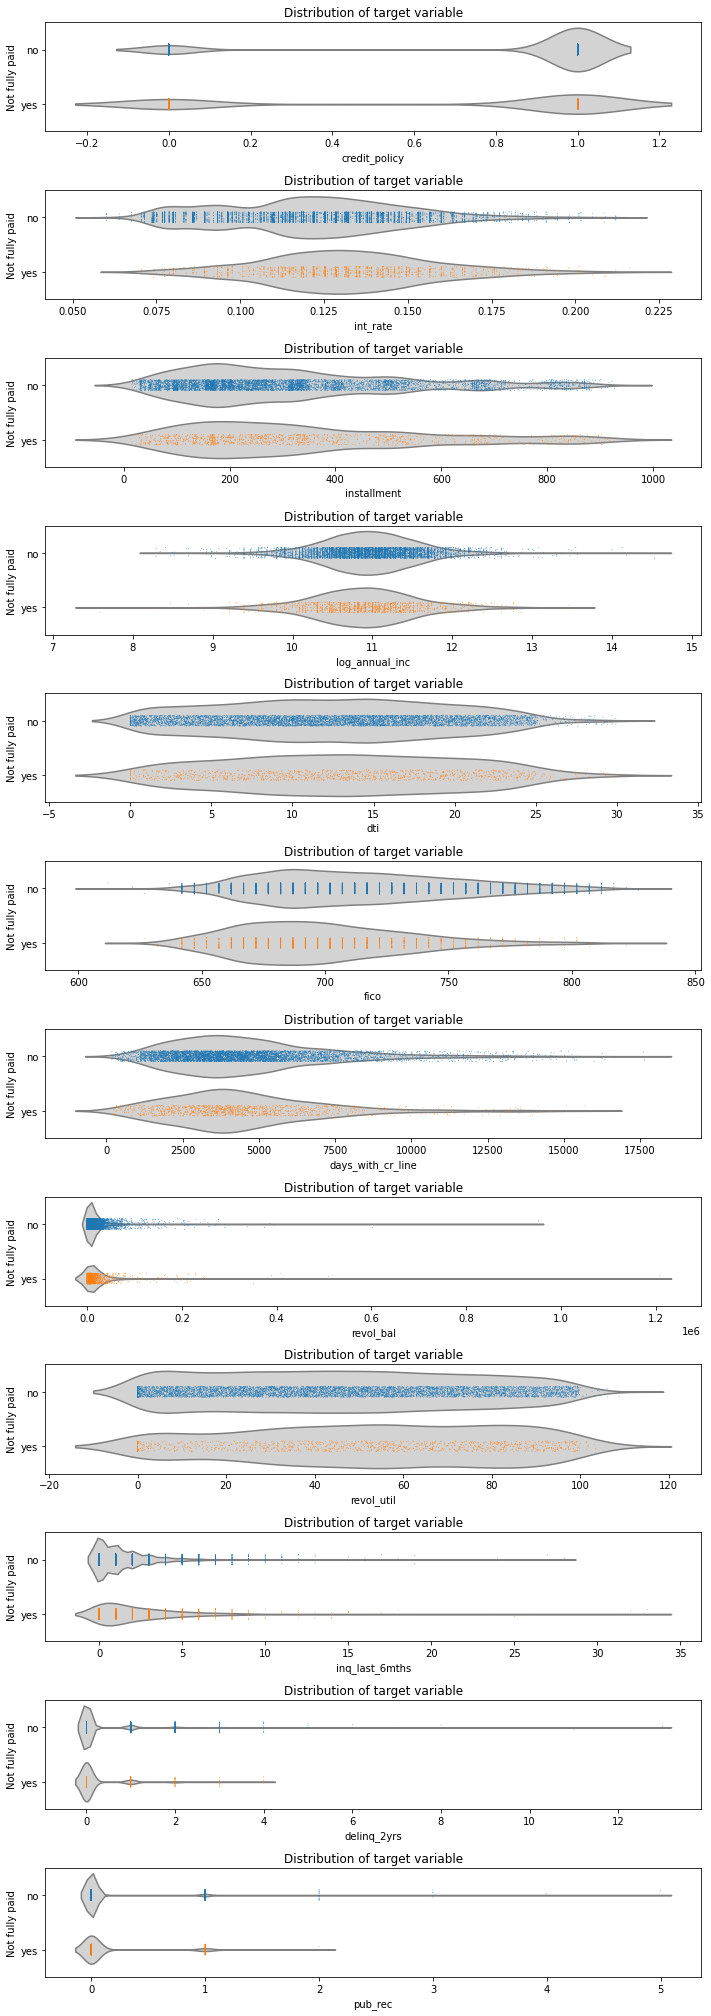

In [37]:
# Check distribution (num)
plt.figure(figsize=(10, 30))
# Plot distribution 
for i, col in enumerate(num):
    plt.subplot(13,1,1+i); sns.violinplot(x=col, y='y', data=train, inner=None, color='lightgray');sns.stripplot(x=col, y='y', data=train, size=0.8,jitter=True);
    plt.title('Distribution of target variable');
    plt.ylabel('Not fully paid')
    # Show the plot
plt.tight_layout()
plt.show()

4. Feature selection

4.1 Number of features to use - PCA analysis

In [38]:
def upsample_data(X, y):
    # Concat
    data = pd.concat([X, y], axis=1)
    #data.head()
    subscribe = data[data['not_fully_paid']==1]
    not_subscribe = data[data['not_fully_paid']==0]
    # Upsample minority and combine with majority
    data_upsampled = resample(not_subscribe, replace=True, n_samples=len(subscribe), random_state=0)
    upsampled = pd.concat([subscribe, data_upsampled])
    # Upsampled feature matrix and target array
    X_up = upsampled.drop('not_fully_paid', axis=1)
    y_up = upsampled[['not_fully_paid']]
    #X_up.head()
    
    return X_up, y_up

In [39]:
# Perform upsample on all dataset
X_train_e_l_n_up, y_train_up = upsample_data(X_train_e_l_n, y_train)
X_test_e_l_n_up, y_test_up = upsample_data(X_test_e_l_n, y_test)
X_valid_e_l_n_up, y_valid_up = upsample_data(X_valid_e_l_n, y_valid)

In [40]:
X_train_e_l_n_up.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2464 entries, 6120 to 9561
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   credit_policy               2464 non-null   float64
 1   int_rate                    2464 non-null   float64
 2   installment                 2464 non-null   float64
 3   log_annual_inc              2464 non-null   float64
 4   dti                         2464 non-null   float64
 5   fico                        2464 non-null   float64
 6   days_with_cr_line           2464 non-null   float64
 7   revol_bal                   2464 non-null   float64
 8   revol_util                  2464 non-null   float64
 9   inq_last_6mths              2464 non-null   float64
 10  delinq_2yrs                 2464 non-null   float64
 11  pub_rec                     2464 non-null   float64
 12  purpose_credit_card         2464 non-null   float64
 13  purpose_debt_consolidation  24

In [41]:
# Set attributes for PCA analysis
n=18
columns=['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5', 'PCA_6', 'PCA_7', 'PCA_8', 'PCA_9', 'PCA_10', 'PCA_11', 'PCA_12', 'PCA_13', 'PCA_14', 'PCA_15', 'PCA_16', 'PCA_17', 'PCA_18']

In [42]:
# Create the PCA instance and fit and transform the data with pca
pca = PCA(n_components=n)
pc = pca.fit_transform(X_train_e_l_n)
df_pc = pd.DataFrame(pc, columns=columns, index=X_train_e_l_n.index)
df_pc.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18
4247,3.256996,-0.246222,-0.206230,0.563453,0.279455,0.575534,3.580817,1.013099,2.437941,0.812285,-0.261670,-0.619781,-0.758068,-0.155953,-0.208116,-0.330471,-0.211646,0.289211
8766,0.244595,2.712633,1.299334,0.651076,1.424221,1.194629,0.524848,0.388815,0.646855,-2.001559,-2.720793,0.043031,0.106035,-0.248603,0.096794,0.496380,-0.080832,-0.153684
1509,-1.932073,-1.556520,-0.110169,-1.357010,-1.221481,1.289136,-0.235875,-1.096475,0.340110,-0.667406,0.256430,-0.086030,-0.649434,0.867972,0.583748,0.003313,-0.041487,0.031403
6120,-0.790266,-1.769093,-1.204595,-1.056188,-0.180938,-0.473822,0.014383,-0.280887,0.036320,-0.028006,0.464979,-0.451753,-0.582352,0.471907,-0.493793,0.173686,0.091046,0.275072
1069,-0.336338,-0.318002,-0.410661,-0.823692,0.829951,-0.399236,0.340919,0.091516,0.033393,-0.549392,-0.076001,0.128169,-0.105765,-0.588484,1.070894,-0.414630,0.122366,-0.359232


In [43]:
pca.explained_variance_ratio_

array([0.15887756, 0.125795  , 0.09042296, 0.07512441, 0.06369233,
       0.06116488, 0.05774666, 0.05561229, 0.05417588, 0.05351061,
       0.04836214, 0.03955678, 0.02852432, 0.02711373, 0.02414615,
       0.01615035, 0.0113211 , 0.00870286])

In [44]:
# PCA df which store PCA componenets and corresponding y
df_PCA = pd.concat([df_pc, y_train], axis=1)
df_PCA.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15,PCA_16,PCA_17,PCA_18,not_fully_paid
4247,3.256996,-0.246222,-0.206230,0.563453,0.279455,0.575534,3.580817,1.013099,2.437941,0.812285,-0.261670,-0.619781,-0.758068,-0.155953,-0.208116,-0.330471,-0.211646,0.289211,0
8766,0.244595,2.712633,1.299334,0.651076,1.424221,1.194629,0.524848,0.388815,0.646855,-2.001559,-2.720793,0.043031,0.106035,-0.248603,0.096794,0.496380,-0.080832,-0.153684,0
1509,-1.932073,-1.556520,-0.110169,-1.357010,-1.221481,1.289136,-0.235875,-1.096475,0.340110,-0.667406,0.256430,-0.086030,-0.649434,0.867972,0.583748,0.003313,-0.041487,0.031403,0
6120,-0.790266,-1.769093,-1.204595,-1.056188,-0.180938,-0.473822,0.014383,-0.280887,0.036320,-0.028006,0.464979,-0.451753,-0.582352,0.471907,-0.493793,0.173686,0.091046,0.275072,1
1069,-0.336338,-0.318002,-0.410661,-0.823692,0.829951,-0.399236,0.340919,0.091516,0.033393,-0.549392,-0.076001,0.128169,-0.105765,-0.588484,1.070894,-0.414630,0.122366,-0.359232,0


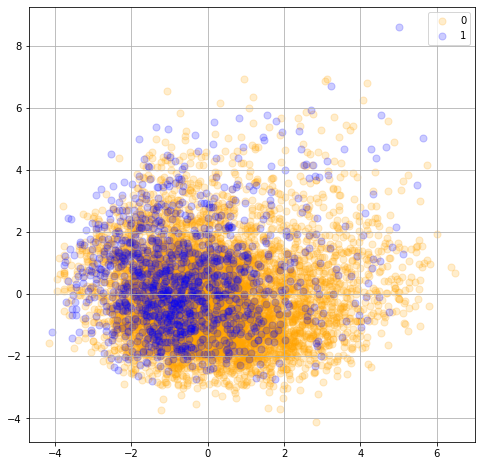

In [45]:
targets = [0, 1]
colors = ['orange', 'blue']

fig, ax = plt.subplots(figsize=(8,8))


# For loop to create plot
for target, color in zip(targets,colors):
    indicesToKeep = df_PCA['not_fully_paid'] == target
    ax.scatter(df_PCA.loc[indicesToKeep, 'PCA_1']
               , df_PCA.loc[indicesToKeep, 'PCA_2']
               , c = color
               , s = 50
              , alpha =0.2)

# Legend    
ax.legend(targets)
ax.grid()
plt.show()

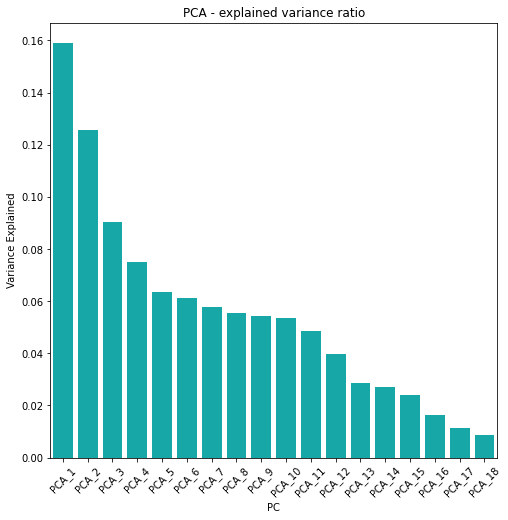

In [46]:
# Instantiate
pca = PCA(n_components=n)

# Fit and transform
principalComponents = pca.fit_transform(X_train_e_l_n)

# List principal components names
principal_components =columns

# Create a DataFrame
pca_df = pd.DataFrame({'Variance Explained': pca.explained_variance_ratio_,
             'PC':principal_components})

plt.figure(figsize=(8, 8))
plt.title('PCA - explained variance ratio')
# Plot DataFrame
sns.barplot(x='PC',y='Variance Explained', 
           data=pca_df, color="c")
plt.xticks(rotation=45)
plt.show()

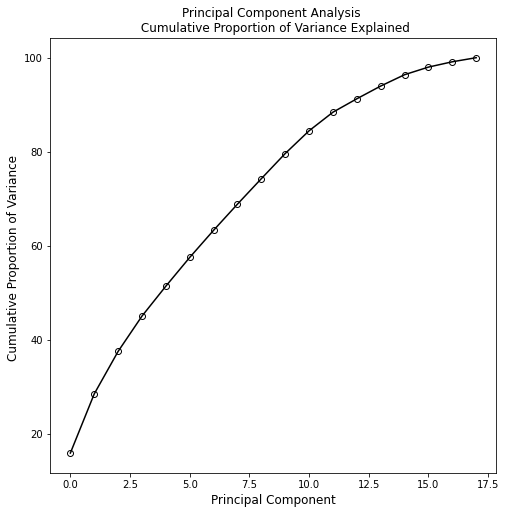

In [47]:
plt.figure(figsize=(8, 8))
# Instantiate, fit and transform
#pca2 = PCA()
#principalComponents2 = pca2.fit_transform(X_train_valid_e_n_up)

# Assign variance explained
var = pca.explained_variance_ratio_

# Plot cumulative variance
cumulative_var = np.cumsum(var)*100
plt.plot(cumulative_var,'k-o',markerfacecolor='None',markeredgecolor='k')
plt.title('Principal Component Analysis \n Cumulative Proportion of Variance Explained',fontsize=12)
plt.xlabel("Principal Component",fontsize=12)
plt.ylabel("Cumulative Proportion of Variance ",fontsize=12)
plt.show()

In [78]:
# Function to find lowest C and plot the result
def lowest_err(model, C_values, train_errs, valid_errs):
    
    # Print lowest valid err 
    C_values_df = pd.DataFrame(C_values)
    valid_errs_df = pd.DataFrame(valid_errs)
    min_err = min(valid_errs_df[0])
    min_idx = valid_errs_df[0].idxmin(axis = 1)
    min_C = C_values_df.loc[min_idx, 0]
    print(f'Min validation error ({model})  occur at C={round(min_C, 5)} and error = {round(min_err,5)}')

    # Plot results
    plt.figure(figsize=(8,5))
    plt.semilogx(C_values, train_errs, C_values, valid_errs)
    plt.annotate(f'Min error occur at Hyper-param ={round(min_C, 5)} and error = {round(min_err,5)}', xy=(min_C, min_err),fontsize=12,arrowprops=dict(facecolor='red', shrink=0.5),)
    plt.legend(("train", "validation"))
    plt.title(model)
    plt.xlabel('Hyper-parameter')
    plt.ylabel('Error')
    plt.show()
    
    # Return
    return {'Model':model, 'Best hyperparam': min_C}

In [79]:
min_C = list()

In [81]:
# Train and validaton errors initialized as empty list
train_errs = list()
valid_errs = list()
C_values = np.logspace(-6, -2, 21)

# Loop over values of C_value
for C_value in C_values:
    # Create LogisticRegression object and fit
    clf = LogisticRegression(C=C_value)
    clf.fit(X_train_e_l_n_up, y_train_up)
    
    # Evaluate error rates and append to lists
    train_errs.append( 1.0 - clf.score(X_train_e_l_n_up, y_train_up) )
    valid_errs.append( 1.0 - clf.score(X_valid_e_l_n_up, y_valid_up) )

In [71]:
C_values

array([1.00000000e-06, 1.58489319e-06, 2.51188643e-06, 3.98107171e-06,
       6.30957344e-06, 1.00000000e-05, 1.58489319e-05, 2.51188643e-05,
       3.98107171e-05, 6.30957344e-05, 1.00000000e-04, 1.58489319e-04,
       2.51188643e-04, 3.98107171e-04, 6.30957344e-04, 1.00000000e-03,
       1.58489319e-03, 2.51188643e-03, 3.98107171e-03, 6.30957344e-03,
       1.00000000e-02])

In [72]:
train_errs

[0.3892045454545454,
 0.3892045454545454,
 0.3892045454545454,
 0.3892045454545454,
 0.3831168831168831,
 0.3831168831168831,
 0.3831168831168831,
 0.38514610389610393,
 0.38514610389610393,
 0.38555194805194803,
 0.38555194805194803,
 0.38676948051948057,
 0.3871753246753247,
 0.3883928571428571,
 0.3883928571428571,
 0.38555194805194803,
 0.382711038961039,
 0.382711038961039,
 0.38189935064935066,
 0.3794642857142857,
 0.3782467532467533]

In [73]:
valid_errs

[0.3853820598006644,
 0.3853820598006644,
 0.3870431893687708,
 0.3870431893687708,
 0.3737541528239202,
 0.3737541528239202,
 0.3737541528239202,
 0.3737541528239202,
 0.3754152823920266,
 0.3737541528239202,
 0.3754152823920266,
 0.3754152823920266,
 0.3754152823920266,
 0.3754152823920266,
 0.3820598006644518,
 0.3820598006644518,
 0.38372093023255816,
 0.39036544850498334,
 0.38870431893687707,
 0.39036544850498334,
 0.38870431893687707]

In [82]:
lowest_err('Logistic regression', C_values, train_errs, valid_errs)

ValueError: `axis` must be fewer than the number of dimensions (1)

In [68]:
# Plot and find min C
min_C.append( lowest_err('Logistic regression', C_values, train_errs, valid_errs) )

ValueError: `axis` must be fewer than the number of dimensions (1)

In [59]:
# Train and validaton errors initialized as empty list
train_errs = list()
valid_errs = list()
C_values = [int(x) for x in np.linspace(1, 900, 21)]

# Loop over values of C_value
for C_value in C_values:
    # Create LogisticRegression object and fit
    clf = GradientBoostingClassifier(n_estimators=C_value)
    clf.fit(X_train_e_l_n_up, y_train_up)
    
    # Evaluate error rates and append to lists
    train_errs.append( 1.0 - clf.score(X_train_e_l_n_up, y_train_up) )
    valid_errs.append( 1.0 - clf.score(X_valid_e_l_n_up, y_valid_up) )

In [62]:
# Plot and find min C
min_C.append( lowest_err('Gradient boosting', C_values, train_errs, valid_errs) )

ValueError: `axis` must be fewer than the number of dimensions (1)

In [75]:
# Refit model with both train and valid data
X_train_valid_e_l_n_up = pd.concat([X_train_e_l_n_up, X_valid_e_l_n_up], axis=0)
X_train_valid_e_l_n_up.tail()


,credit_policy,int_rate,installment,log_annual_inc,dti,fico,days_with_cr_line,revol_bal,revol_util,inq_last_6mths,delinq_2yrs,pub_rec,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
7689,0.491133,-0.740864,-0.362008,-0.199555,0.920389,-0.082211,-1.168804,0.590105,0.411253,0.591812,-0.344128,-0.250163,-0.394533,-0.829928,-0.190751,-0.268716,-0.216812,-0.263656
1468,0.491133,-0.759885,-1.218471,-0.926699,-0.863583,0.183844,1.476485,-0.806279,-2.132814,-0.018574,3.546869,-0.250163,-0.394533,-0.829928,-0.190751,-0.268716,-0.216812,-0.263656
4265,0.491133,-1.706565,-0.201707,-0.283128,0.725602,1.086707,0.329707,0.111511,0.057362,-0.018574,-0.344128,-0.250163,-0.394533,1.204923,-0.190751,-0.268716,-0.216812,-0.263656
7582,0.491133,0.878172,1.368579,-0.646700,0.584284,-0.764148,-0.822087,-0.632073,-0.755961,-0.018574,2.110818,-0.250163,-0.394533,1.204923,-0.190751,-0.268716,-0.216812,-0.263656
4256,0.491133,-1.706565,0.285276,-0.266067,-1.644391,2.187756,0.534011,-0.087493,-0.719014,-1.062034,-0.344128,-0.250163,-0.394533,1.204923,-0.190751,-0.268716,-0.216812,-0.263656


In [83]:
y_train_valid_e_l_n_up = pd.concat([y_train_up,y_valid_up], axis=0)
y_train_valid_e_l_n_up.tail()

,not_fully_paid
7689,0
1468,0
4265,0
7582,0
4256,0


In [84]:
# Set RFE params
n_features_to_select = 12
step = 1

In [87]:
# RFE with Logistic regression
rfe_lg = RFE(estimator=LogisticRegression(C=min_C.loc['Logistic regression', 'Best hyperparam']), 
             n_features_to_select=n_features_to_select, step=step, verbose=1)
rfe_lg.fit(X_train_valid_e_l_n_up, y_train_valid_e_l_n_up)
# Calculate the score on the test set
#score = rfe_lg.score(X_test_e_l_n, y_test)
score = rfe_lg.score(X_test_e_l_n_up, y_test_up)
print('Logistic regression can explain {0:.1%} of the variance in the test set'.format(score))
# Assign the support array to mask
lg_mask = rfe_lg.support_

AttributeError: 'list' object has no attribute 'loc'